# 폰트 관련 설치

In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [2]:
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm

# # 나눔고딕 폰트 경로
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# # 폰트 프로퍼티 생성
# font_prop = fm.FontProperties(fname=font_path)
# plt.rc('font', family=font_prop.get_name())

# # 한글 폰트가 제대로 설정되었는지 확인
# print("현재 설정된 폰트:", plt.rcParams['font.family'])

현재 설정된 폰트: ['NanumGothic']


# 모델링을 위한 optuna 설치

In [3]:
# pip install -q optuna

# 모듈 불러오기

In [4]:
import pandas as pd
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import LabelEncoder

# customers 테이블에서 1번과 그 이상의 고객 고유 ID 리스트 뽑기

In [5]:
cus_final = pd.read_csv('/content/drive/MyDrive/멋사 프로그래밍/13. 데이터톤/open_final/customers_final.csv')
cus_final.head()

,고객 ID,고객 고유 ID,우편번호 앞부분,도시,주,고객 도시,주 한국명,지역
0,CUSTOMER_00000,CUSTOMER_Unique_00000,14409,franca,SP,franca,상파울루주,남동부
1,CUSTOMER_00001,CUSTOMER_Unique_00001,9790,sao bernardo do campo,SP,sao bernardo do campo,상파울루주,남동부
2,CUSTOMER_00002,CUSTOMER_Unique_00002,1151,sao paulo,SP,sao paulo,상파울루주,남동부
3,CUSTOMER_00003,CUSTOMER_Unique_00003,8775,mogi das cruzes,SP,mogi das cruzes,상파울루주,남동부
4,CUSTOMER_00004,CUSTOMER_Unique_00004,89254,jaragua do sul,SC,jaragua do sul,산타카타리나주,남부


In [6]:
tmp = cus_final.groupby('고객 고유 ID', as_index = False)['고객 ID'].count()
tmp.head()

,고객 고유 ID,고객 ID
0,CUSTOMER_Unique_00000,1
1,CUSTOMER_Unique_00001,1
2,CUSTOMER_Unique_00002,1
3,CUSTOMER_Unique_00003,1
4,CUSTOMER_Unique_00004,2


In [7]:
tmp1 = tmp.loc[tmp['고객 ID'] > 1]
tmp2 = tmp.loc[tmp['고객 ID'] == 1]
# 1번보다 많이 구매한 고객의 고객 고유 ID 리스트
revisit_list = list(tmp1['고객 고유 ID'])
# 1번 구매한 고객의 고객 고유 ID 리스트
onetime_list = list(tmp2['고객 고유 ID'])

# 전처리

In [8]:
final = pd.read_csv('/content/drive/MyDrive/멋사 프로그래밍/13. 데이터톤/최종합본_final.csv')
final.head()

,Unnamed: 0,주문 고유 ID,고객 ID,주문 상태,구매 시간,물류 처리 시간,실제 배송 날짜,기대 배송 날짜,고객 고유 ID,우편번호 앞부분,...,카테고리 이름,제품 무게(g),제품 길이(cm),제품 높이(cm),제품 너비(cm),상위 카테고리,판매자 우편번호 앞자리,판매자 도시(city),판매자 주(state),총구매금액
0,0,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,CUSTOMER_Unique_60785,3149,...,home_utilities,500.0,19.0,8.0,13.0,home,9350.0,maua,SP,543.4188
1,1,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,CUSTOMER_Unique_60785,3149,...,home_utilities,500.0,19.0,8.0,13.0,home,9350.0,maua,SP,59.9800
2,2,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18,CUSTOMER_Unique_60785,3149,...,home_utilities,500.0,19.0,8.0,13.0,home,9350.0,maua,SP,557.5141
3,3,ORDER_00001,CUSTOMER_54059,delivered,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15,CUSTOMER_Unique_52983,59296,...,pet_shop,450.0,30.0,10.0,20.0,pets,31842.0,belo horizonte,MG,3249.0000
4,4,ORDER_00002,CUSTOMER_59535,delivered,2019-02-13 21:18:39,2019-02-14 19:46:34,2019-02-16 18:17:02,2019-02-26,CUSTOMER_Unique_58227,9195,...,stationery,250.0,51.0,15.0,15.0,office_supplies,8752.0,mogi das cruzes,SP,569.5380


## 시간 타입으로 변경

In [9]:
final['구매 시간'] = pd.to_datetime(final['구매 시간']).astype('datetime64[ns]')
final['물류 처리 시간'] = pd.to_datetime(final['물류 처리 시간']).astype('datetime64[ns]')
final['실제 배송 날짜'] = pd.to_datetime(final['실제 배송 날짜']).astype('datetime64[ns]')
final['기대 배송 날짜'] = pd.to_datetime(final['기대 배송 날짜']).astype('datetime64[ns]')

final['리뷰 생성 시간'] = pd.to_datetime(final['리뷰 생성 시간']).astype('datetime64[ns]')
final['리뷰 답변 시간'] = pd.to_datetime(final['리뷰 답변 시간']).astype('datetime64[ns]')

## 파생 변수 추가

In [10]:
# 한 고객이 한 번 구매할 때의 총 금액
final['총 금액'] = final['판매 가격'] + final['품목 화물 가격']
# 세 컬럼으로 부피를 계산해 하나의 컬럼으로 축소
final['부피'] = final['제품 길이(cm)'] * final['제품 높이(cm)'] * final['제품 너비(cm)']

# 시간 컬럼을 쉽게 전처리하기 위해 배송 간의 시간을 확인하는 컬럼 추가
final['배송 시간'] = final['실제 배송 날짜'] - final['구매 시간']
final['기대실제 배송시간'] = final['기대 배송 날짜'] - final['실제 배송 날짜']
final['답변 시간'] = final['리뷰 답변 시간'] - final['리뷰 생성 시간']

## 사용하지 않을 컬럼 및 파생 변수 생성 시 사용한 변수들 제거

In [11]:
final.drop(columns= ['Unnamed: 0', '판매자 고유 ID',  '리뷰 고유 ID', '구매 시간', '물류 처리 시간', '실제 배송 날짜', '기대 배송 날짜', '총구매금액', '거래 금액', '리뷰 생성 시간', '리뷰 답변 시간'], inplace = True)

## 중복 행을 제거

In [12]:
final = final.drop_duplicates(subset = ['주문 고유 ID', '고객 ID', '고객 고유 ID'])

# 해당 로우는 주문 품목 수, 물품의 무게 등에 관한 정보가 없어서 1개의 로우 제거

In [13]:
final.drop(final.loc[final['주문 품목 수'].isnull()].index, inplace = True)

## 결측치 값들을 대체

In [14]:
final['주 한국명'] = final['주 한국명'].fillna('Unknown')
final['지역'] = final['지역'].fillna('Unknown')
final['고객 위도'] = final['고객 위도'].fillna(final['고객 위도'].median())
final['고객 경도'] = final['고객 경도'].fillna(final['고객 경도'].median())

final['카테고리 이름'] = final['카테고리 이름'].fillna('Unknown')
final['상위 카테고리'] = final['상위 카테고리'].fillna('Unknown')

final['부피'] = final['부피'].fillna(round(final['부피'].mean(),0))
final['제품 무게(g)'] = final['제품 무게(g)'].fillna(round(final['제품 무게(g)'].mean(),0))
final['제품 길이(cm)'] = final['제품 길이(cm)'].fillna(round(final['제품 길이(cm)'].mean(),0))
final['제품 높이(cm)'] = final['제품 높이(cm)'].fillna(round(final['제품 높이(cm)'].mean(),0))
final['제품 너비(cm)'] = final['제품 너비(cm)'].fillna(round(final['제품 너비(cm)'].mean(),0))

final['리뷰 점수'] = final['리뷰 점수'].fillna(final['리뷰 점수'].mode().values[0])
final['답변 시간'] = final['답변 시간'].fillna(datetime.timedelta(days = 1))

In [15]:
final.isnull().sum()

주문 고유 ID        0
고객 ID           0
주문 상태           0
고객 고유 ID        0
우편번호 앞부분        0
도시              0
주               0
주 한국명           0
지역              0
고객 위도           0
고객 경도           0
주문 품목 수         0
제품 고유 ID        0
판매 가격           0
품목 화물 가격        0
결제 시퀀스          0
지불 방법           0
할부 횟수           0
리뷰 점수           0
카테고리 이름         0
제품 무게(g)        0
제품 길이(cm)       0
제품 높이(cm)       0
제품 너비(cm)       0
상위 카테고리         0
판매자 우편번호 앞자리    0
판매자 도시(city)    0
판매자 주(state)    0
총 금액            0
부피              0
배송 시간           0
기대실제 배송시간       0
답변 시간           0
dtype: int64

# 중복 제거를 통해 바뀐 인덱스를 재정렬

In [16]:
final = final.reset_index(drop = True)

## 이탈 : 재구매가 이루어지지 않으면 이탈로 정의
  - 이탈을 하지 않았으면 1, 이탈을 하면 0

### 이탈 컬럼을 일괄적으로 추가

In [17]:
final['이탈 고객'] = 0

### 정의한 이탈에 따라 재구매한 고객들을 대상으로 1로 변경

In [18]:
final.loc[final['고객 고유 ID'].isin(revisit_list), '이탈 고객' :] = 1

### ID 관련 컬럼 삭제

In [19]:
final.drop(columns = ['주문 고유 ID', '고객 ID', '고객 고유 ID', '제품 고유 ID'], inplace = True)

## timedelta 컬럼 days의 숫자로 변경

In [20]:
final['배송 시간'] = final['배송 시간'].dt.days
final['기대실제 배송시간'] = final['기대실제 배송시간'].dt.days
final['답변 시간'] = final['답변 시간'].dt.days

# 범주형 변수 처리 전 파일 저장

In [21]:
# final.to_csv('시각화_버전.csv', index = False)

## 범주형 변수 관련 인코딩

In [22]:
cat_list = ['주문 상태', '도시', '주', '주 한국명', '지역', '지불 방법 ', '카테고리 이름', '상위 카테고리', '판매자 도시(city)', '판매자 주(state)']

In [23]:
le = LabelEncoder()

for cat in cat_list:
  final[cat] = le.fit_transform(final[cat])

## csv 파일로 변환

In [24]:
# final.to_csv('final_전처리_컬럼안제거_버전.csv', index = False)

# 전처리한 파일 불러오기

In [25]:
final = pd.read_csv('/content/drive/MyDrive/멋사 프로그래밍/13. 데이터톤/final_전처리_컬럼안제거_버전.csv')
final.head()

,주문 상태,우편번호 앞부분,도시,주,주 한국명,지역,고객 위도,고객 경도,주문 품목 수,판매 가격,...,상위 카테고리,판매자 우편번호 앞자리,판매자 도시(city),판매자 주(state),총 금액,부피,배송 시간,기대실제 배송시간,답변 시간,이탈 고객
0,1,3149,3476,25,9,1,-23.575816,-46.587303,1.0,29.99,...,10,9350.0,309,21,38.71,1976.0,8,7,1,1
1,1,59296,3355,19,26,3,-5.773971,-35.273838,1.0,45.00,...,15,31842.0,61,7,72.20,6000.0,13,12,2,0
2,1,9195,3264,25,9,1,-23.675471,-46.514788,1.0,19.90,...,14,8752.0,318,21,28.62,11475.0,2,9,1,0
3,1,86320,1000,17,19,2,-23.551117,-50.551613,1.0,147.90,...,2,7112.0,208,21,175.26,42250.0,16,5,0,0
4,1,26525,2375,18,2,1,-22.805728,-43.423190,1.0,59.99,...,2,12940.0,37,21,75.16,4352.0,9,11,1,0


# 정답 레이블 분리

In [26]:
X = final.drop(columns = ['이탈 고객'])
y = final['이탈 고객']

# train / test 분리

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((65965, 29), (21989, 29), (65965,), (21989,))

# 스케일링

In [28]:
SC = StandardScaler()
X_trans = SC.fit_transform(X_train)

In [29]:
X_test_trans = SC.fit_transform(X_test)

# optuna를 활용한 최적의 파라미터 찾기

In [30]:
# def objective(trial):
#     # 하이퍼파라미터 탐색 공간 정의
#     n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
#     max_depth = trial.suggest_int('max_depth', 5, 15)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     max_features = trial.suggest_categorical('max_features', ['sqrt'])

#     # Random Forest 모델 생성
#     model = RandomForestClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         random_state=42
#     )

#     # 모델 학습
#     model.fit(X_trans, y_train)

#     # 검증 데이터에 대한 예측
#     y_valid_pred = model.predict(X_test_trans)

#     # 검증 데이터에 대한 정확도 계산
#     roc = roc_auc_score(y_test, y_valid_pred)

#     return roc

In [31]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# best_score = study.best_value
# print('Best Parameters:', best_params)
# print('Best roc_auc_score:', best_score)

# 찾은 파라미터로 모델링 진행

In [32]:
RC = RandomForestClassifier(n_estimators = 900, max_depth = 7, min_samples_split = 2, min_samples_leaf = 9, max_features = 'sqrt', random_state = 42)
model = RC.fit(X_trans, y_train)

In [33]:
y_pred = model.predict(X_test_trans)

# 성능 평가

In [34]:
roc_auc_score(y_test, y_pred)

0.5

# Feature_importance 탐색

In [35]:
importances = pd.Series(model.feature_importances_, index = X.columns)
importances

주문 상태           0.000000
우편번호 앞부분        0.050470
도시              0.033602
주               0.012446
주 한국명           0.014687
지역              0.005987
고객 위도           0.046614
고객 경도           0.057748
주문 품목 수         0.000000
판매 가격           0.083135
품목 화물 가격        0.047614
결제 시퀀스          0.002191
지불 방법           0.009083
할부 횟수           0.066300
리뷰 점수           0.009223
카테고리 이름         0.043908
제품 무게(g)        0.037600
제품 길이(cm)       0.027897
제품 높이(cm)       0.033224
제품 너비(cm)       0.028761
상위 카테고리         0.054602
판매자 우편번호 앞자리    0.049501
판매자 도시(city)    0.048590
판매자 주(state)    0.014341
총 금액            0.099461
부피              0.043265
배송 시간           0.022176
기대실제 배송시간       0.042207
답변 시간           0.015367
dtype: float64

## features들 정렬

In [36]:
imp = importances.sort_values(ascending = False)
imp

총 금액            0.099461
판매 가격           0.083135
할부 횟수           0.066300
고객 경도           0.057748
상위 카테고리         0.054602
우편번호 앞부분        0.050470
판매자 우편번호 앞자리    0.049501
판매자 도시(city)    0.048590
품목 화물 가격        0.047614
고객 위도           0.046614
카테고리 이름         0.043908
부피              0.043265
기대실제 배송시간       0.042207
제품 무게(g)        0.037600
도시              0.033602
제품 높이(cm)       0.033224
제품 너비(cm)       0.028761
제품 길이(cm)       0.027897
배송 시간           0.022176
답변 시간           0.015367
주 한국명           0.014687
판매자 주(state)    0.014341
주               0.012446
리뷰 점수           0.009223
지불 방법           0.009083
지역              0.005987
결제 시퀀스          0.002191
주문 품목 수         0.000000
주문 상태           0.000000
dtype: float64

# Feature_importance 시각화

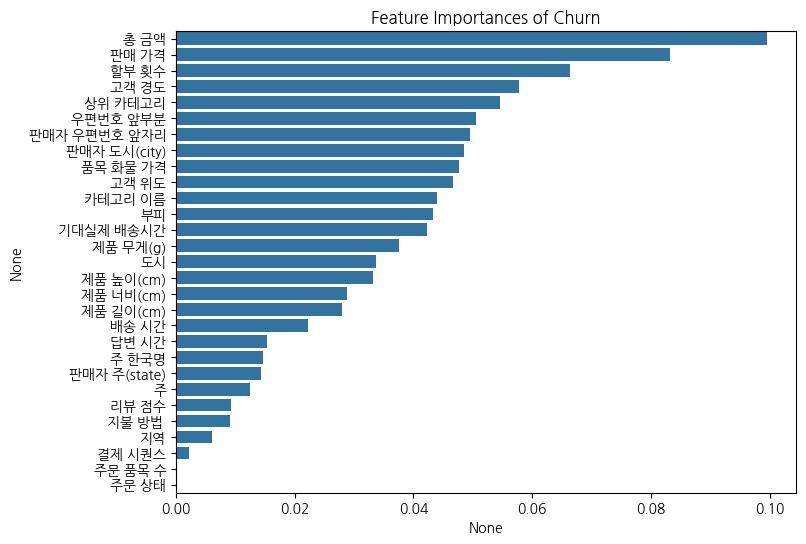

In [37]:
import seaborn as sns

plt.figure(figsize=(8,6))
plt.title('Feature Importances of Churn')
sns.barplot(x= imp, y= imp.index)
plt.show()

# feature_importance에 따른 시각화 및 인사이트 도출

In [38]:
vis = pd.read_csv('/content/시각화_버전.csv')

- 총 금액 = 판매 가격 + 화물 가격
- 총 금액은 판매 가격과 화물 가격으로 이루어진 금액이기에 두 컬럼을 따로 확인
- 판매 가격을 확인해 보았을 때 0 ~ 1000 대의 분포가 대부분
  - 1번 주문하는 고객이 대다수이지만 그 고객 마저도 낮은 금액대의 분포를 보인다.

<Axes: xlabel='판매 가격', ylabel='Count'>

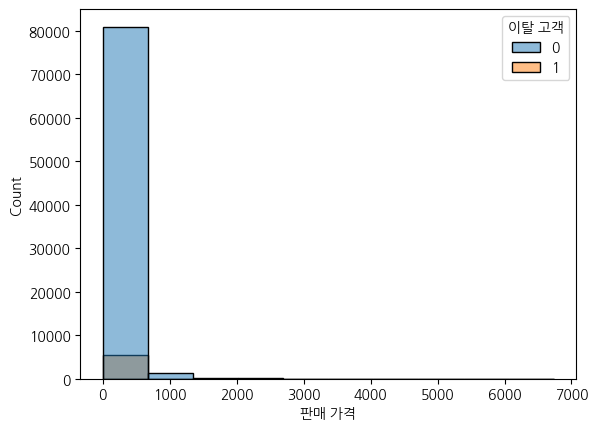

In [39]:
sns.histplot(x = vis['판매 가격'], bins = 10, hue = vis['이탈 고객'])

In [40]:
tmp = vis.loc[vis['이탈 고객'] == 0]

<Axes: xlabel='판매 가격', ylabel='Count'>

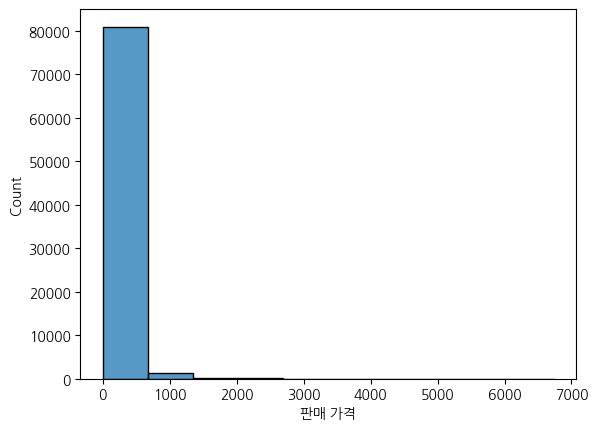

In [41]:
sns.histplot(x = tmp['판매 가격'], bins = 10)

In [42]:
tmp = pd.DataFrame(vis.loc[vis['판매 가격'] < 1000]['상위 카테고리'].value_counts())
tmp.reset_index(inplace = True)

- 금액대가 1000원 미만인 품목들의 카테고리를 파악
  - 판매가격이 이탈율에 큰 영향을 미치며
  - 대부분의 이탈 고객이 낮은 금액대에 분포하기 때문에 현재 많이 소비된 상위 5개의 카테고리에 집중해서 고객들에게 광고를 하면 효과가 좋을 것으로 예상

<ipython-input-43-838729e3eedd>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = tmp, x = '상위 카테고리', y = 'count', palette='Paired')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'home'),
  Text(1, 0, 'electronics'),
  Text(2, 0, 'health_beauty'),
  Text(3, 0, 'fashion'),
  Text(4, 0, 'sports'),
  Text(5, 0, 'miscellaneous'),
  Text(6, 0, 'toys'),
  Text(7, 0, 'automotive'),
  Text(8, 0, 'baby'),
  Text(9, 0, 'office_supplies'),
  Text(10, 0, 'construction'),
  Text(11, 0, 'pets'),
  Text(12, 0, 'food_drink'),
  Text(13, 0, 'books'),
  Text(14, 0, 'music'),
  Text(15, 0, 'industry_commerce'),
  Text(16, 0, 'arts_crafts'),
  Text(17, 0, 'Unknown'),
  Text(18, 0, 'services')])

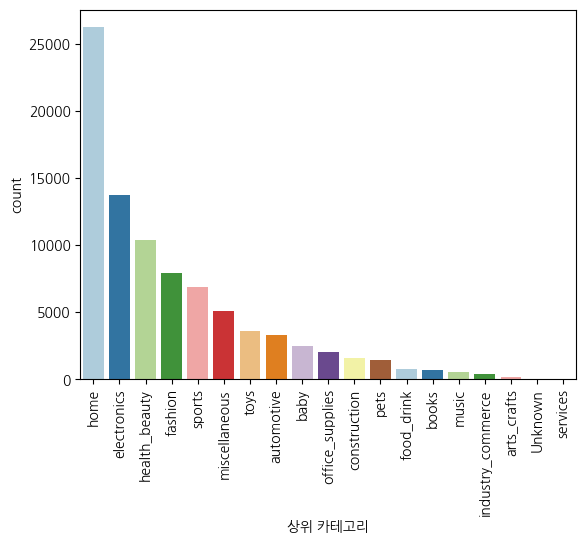

In [43]:
sns.barplot(data = tmp, x = '상위 카테고리', y = 'count', palette='Paired')
plt.xticks(rotation = 90)

- 할부 횟수가 이탈율에 영향을 끼치는 것으로 나온다.
- 해당 변수는 브라질의 이자율의 특성때문에 나온 것으로 생각이 된다.
  - 할부 횟수가 높을 수록 이자율이 크게 올라간다고 한다.


<Axes: xlabel='할부 횟수', ylabel='Count'>

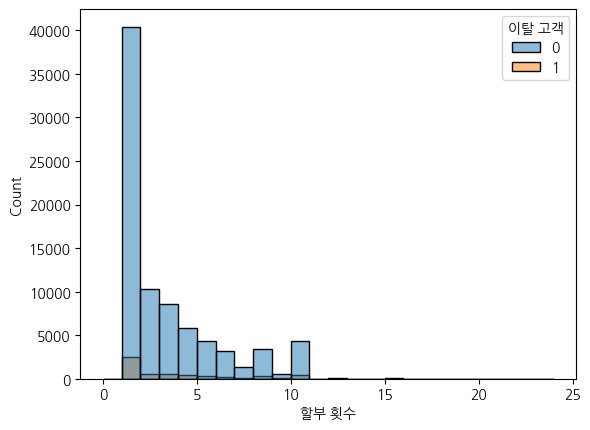

In [44]:
sns.histplot(x = vis['할부 횟수'], bins = 24, hue = vis['이탈 고객'])